#  Taxi orders prediction.

**Data:** ≈ 10 million records of taxi trips in Chicago (open data from the City of Chicago website - [2022](https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz) and [2023](https://data.cityofchicago.org/Transportation/Taxi-Trips-2023/e55j-2ewb)).

**Task:** Develop ML-solution for prediction number of orders for the next hour in each city district with use of PySpark on a local cluster of Docker containers.

## Loading datasets and EDA.

### Installing software packages and importing necessary libraries.

In [1]:
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=NumbaPendingDeprecationWarning)

In [2]:
from datetime import datetime, timedelta

import pandas as pd

import numpy as np

from math import pi

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from statsmodels.tsa.seasonal import seasonal_decompose

import pyspark
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import (
    isnan, col, desc, isnull, to_timestamp, unix_timestamp, abs,
    percent_rank, when, min, max, explode, hour, minute, second, count, dayofweek, sin, cos)
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql import functions as F
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import gc

from tqdm import tqdm

### Creating a Spark session.

In [3]:
SPARK_MASTER_IP = '172.18.0.2'
spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
    .master(f"spark://{SPARK_MASTER_IP}:7077") \
    .config("spark.executor.cores", 1) \
    .config("spark.task.cpus", 1) \
    .getOrCreate()

### Loading datasets.

In [4]:
taxi_2022 = spark.read.load('Taxi_Trips_2022.csv', format="csv", sep=",", inferSchema=True, header="true")
taxi_2022.printSchema()
taxi_2022.show(10)

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [5]:
print(taxi_2022.count())

6382425


In [6]:
taxi_2023 = spark.read.load('Taxi_Trips_2023.csv', format="csv", sep=",", inferSchema=True, header="true")
taxi_2023.printSchema()
taxi_2023.show(10)

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [7]:
print(taxi_2023.count())

3783730


### Merge of datasets.


In [8]:
data = taxi_2022.union(taxi_2023)

In [9]:
print(data.count())

10166155


### Converting Trip Start Timestamp column from a string to timestamp.


In [10]:
data = data.withColumn("Trip Start Timestamp", to_timestamp("Trip Start Timestamp", 'MM/dd/yyyy hh:mm:ss a'))

### Sorting merged dataset by the trip start date.


In [11]:
data = data.orderBy("Trip Start Timestamp")

### Creating a sample from the first and last 5000 rows and converting them to a pandas format for EDA.


In [12]:
# Selecting the first 5,000 records
first_5000 = data.limit(5000)

# Selecting the last 5,000 records
last_5000 = data.orderBy(desc("Trip Start Timestamp")).limit(5000)

# Combining both subsets
data_subset = first_5000.union(last_5000)

In [13]:
# Finding the minimum and maximum values of 'Trip Start Timestamp'
min_max_timestamp = data.agg(
    F.min("Trip Start Timestamp").alias("Min Timestamp"),
    F.max("Trip Start Timestamp").alias("Max Timestamp")
)

# Finding unique values of 'Pickup Community Area'
unique_pickup_areas = data.select("Pickup Community Area").distinct()

# Sorting unique values
sorted_pickup_areas = unique_pickup_areas.sort("Pickup Community Area")

# Displaying the results
min_max_timestamp.show()
sorted_pickup_areas.show(100)

+-------------------+-------------------+
|      Min Timestamp|      Max Timestamp|
+-------------------+-------------------+
|2022-01-01 00:00:00|2023-08-01 00:00:00|
+-------------------+-------------------+

+---------------------+
|Pickup Community Area|
+---------------------+
|                 null|
|                    1|
|                    2|
|                    3|
|                    4|
|                    5|
|                    6|
|                    7|
|                    8|
|                    9|
|                   10|
|                   11|
|                   12|
|                   13|
|                   14|
|                   15|
|                   16|
|                   17|
|                   18|
|                   19|
|                   20|
|                   21|
|                   22|
|                   23|
|                   24|
|                   25|
|                   26|
|                   27|
|                   28|
|                   2

### Conclusions:

- Data is available from January 2022 to July 2023 inclusive.
- In the 'Pickup Community Area' column, there are missing values. According to the data description, these missing values indicate that the trip started outside of Chicago. For ML purposes, it's reasonable to assign a separate value (0) for suburban trips and use it to fill in the missing values.
- There is a significant amount of data that is not relevant to the features within the scope of the tas.


## Data preprocessing.

### Removing columns with irrelevant information.


In [14]:
columns_to_drop = ['Trip ID', 'Taxi ID', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Pickup Census Tract',
                   'Dropoff Census Tract', 'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total',
                   'Payment Type', 'Company','Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Pickup Centroid Location',
                   'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid  Location']

data = data.drop(*columns_to_drop)

### Filling missing values in 'Pickup Community Area' column.

In [15]:
data = data.fillna({'Pickup Community Area': 0})

### Aggregating data by hours and city districts.


In [16]:
# Replacing null values with 0
data = data.na.fill({'Pickup Community Area': 0})

# Rounding Trip Start Timestamp to the nearest hour
data = data.withColumn("Trip Start Timestamp", F.date_trunc('hour', data["Trip Start Timestamp"]))

# Grouping and aggregating data
data = (data.groupBy("Trip Start Timestamp", "Pickup Community Area")
            .agg(F.count("*").alias("num_orders"))
            .orderBy("Trip Start Timestamp", "Pickup Community Area"))

In [17]:
data = data.orderBy(["Trip Start Timestamp", "Pickup Community Area"])

In [18]:
print(data.count())

619893


We need to ensure that there are no missing values in the table with aggregated data. Specifically, we want to make sure it contains all possible combinations of Pickup Community Area and Trip Start Timestamp within the range between the minimum and maximum values of this column. To do this, we'll create a DataFrame with all the specified combinations and join it with the DataFrame containing aggregated data on the number of trips.

In [19]:
# Creating a DataFrame with a date range
start = datetime(2022, 1, 1)
end = datetime(2023, 8, 1)
hour_range = [start + timedelta(hours=x) for x in range(0, int((end-start).total_seconds()/3600)+1)]
df_hour_range = spark.createDataFrame(hour_range, "timestamp").withColumnRenamed("value", "Trip Start Timestamp")

# Creating a DataFrame with a range of Pickup Community Area
pickup_areas = range(78)  # 0-77
df_pickup_areas = spark.createDataFrame(pickup_areas, "int").withColumnRenamed("value", "Pickup Community Area")

# Cross-joining date and Pickup Community Area ranges
all_combinations = df_hour_range.crossJoin(df_pickup_areas)

# Left join all combinations with the data
check_df = all_combinations.join(data, ["Trip Start Timestamp", "Pickup Community Area"], "left")

# Checking for null values in 'num_orders'
missing_rows = check_df.filter(check_df.num_orders.isNull())

In [20]:
print("Number of missing rows in aggregated data:", missing_rows.count())

Number of missing rows in aggregated data: 460329



Since missing rows in the aggregated data indicate that there were no orders in the corresponding district at the respective hour, it's logical to fill these missing values in the column with the number of orders with a value of zero.

In [21]:
data = check_df.fillna({'num_orders': 0})

Checking the result.

In [22]:
data = data.orderBy(["Trip Start Timestamp", "Pickup Community Area"])
data.show(78)

+--------------------+---------------------+----------+
|Trip Start Timestamp|Pickup Community Area|num_orders|
+--------------------+---------------------+----------+
| 2022-01-01 00:00:00|                    0|        17|
| 2022-01-01 00:00:00|                    1|         1|
| 2022-01-01 00:00:00|                    2|         3|
| 2022-01-01 00:00:00|                    3|         9|
| 2022-01-01 00:00:00|                    4|         2|
| 2022-01-01 00:00:00|                    5|         0|
| 2022-01-01 00:00:00|                    6|        32|
| 2022-01-01 00:00:00|                    7|        25|
| 2022-01-01 00:00:00|                    8|       190|
| 2022-01-01 00:00:00|                    9|         0|
| 2022-01-01 00:00:00|                   10|         0|
| 2022-01-01 00:00:00|                   11|         1|
| 2022-01-01 00:00:00|                   12|         0|
| 2022-01-01 00:00:00|                   13|         0|
| 2022-01-01 00:00:00|                   14|    

In [23]:
print(data.count())

1080222


### Decomposing data for multiple city districts into trends and seasonality using the seasonal_decompose method.

#### Data for city district 1.


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


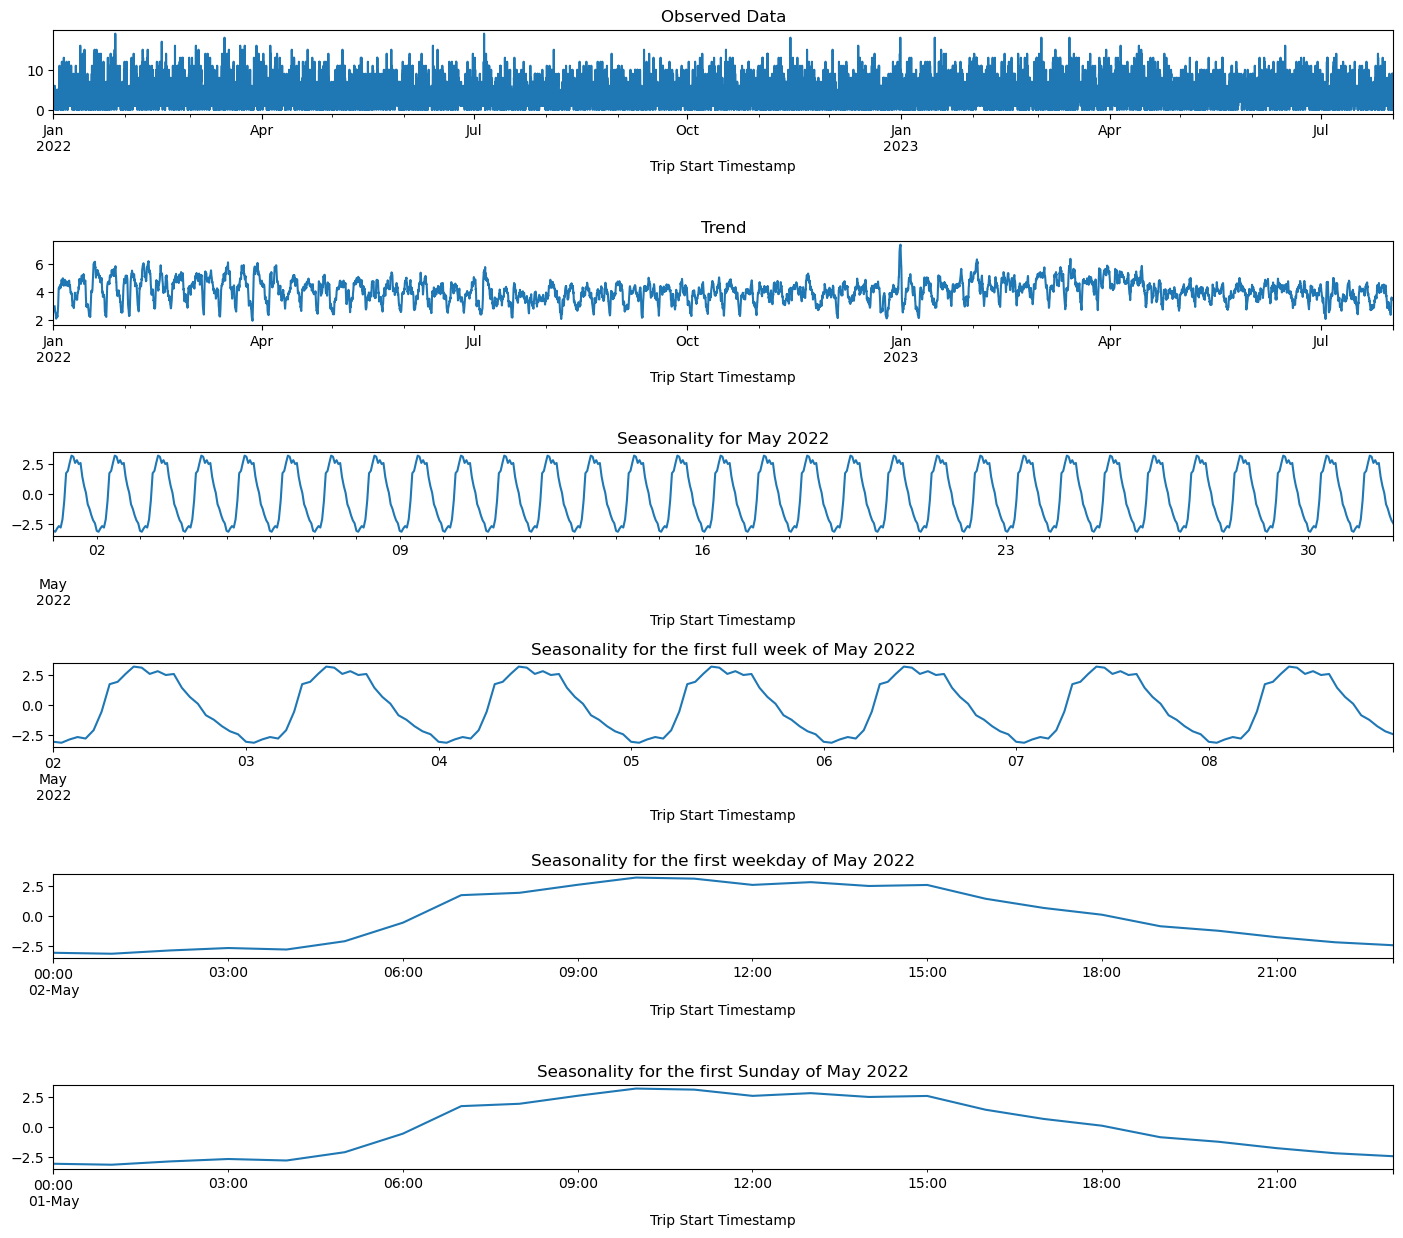

In [24]:
# Filtering data for Pickup Community Area 1
data_filtered = data.filter(data["Pickup Community Area"] == 1)

# Converting to a Pandas DataFrame
pdf = data_filtered.toPandas()

# Converting 'Trip Start Timestamp' to datetime
pdf['Trip Start Timestamp'] = pd.to_datetime(pdf['Trip Start Timestamp']).astype('datetime64[ns]')

# Indexing by 'Trip Start Timestamp'
pdf.set_index('Trip Start Timestamp', inplace=True)

# Applying seasonal_decompose
result = seasonal_decompose(pdf['num_orders'], period=24)

# Plotting the results
plt.figure(figsize=(14,14))

# Observed data
plt.subplot(711)
result.observed.plot(title='Observed Data')

# Trend
plt.subplot(712)
result.trend.plot(title='Trend')

# Seasonality for May 2022
plt.subplot(713)
result.seasonal['2022-05'].plot(title='Seasonality for May 2022')

# Seasonality for the first full week of May (Monday to Sunday inclusive)
plt.subplot(714)
result.seasonal['2022-05-02':'2022-05-08'].plot(title='Seasonality for the first full week of May 2022')

# Seasonality for the first weekday of May
plt.subplot(715)
result.seasonal['2022-05-02'].plot(title='Seasonality for the first weekday of May 2022')

# Seasonality for the first Sunday of May
plt.subplot(716)
result.seasonal['2022-05-01'].plot(title='Seasonality for the first Sunday of May 2022')

plt.tight_layout()
plt.show()

#### Data for city district 8.

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


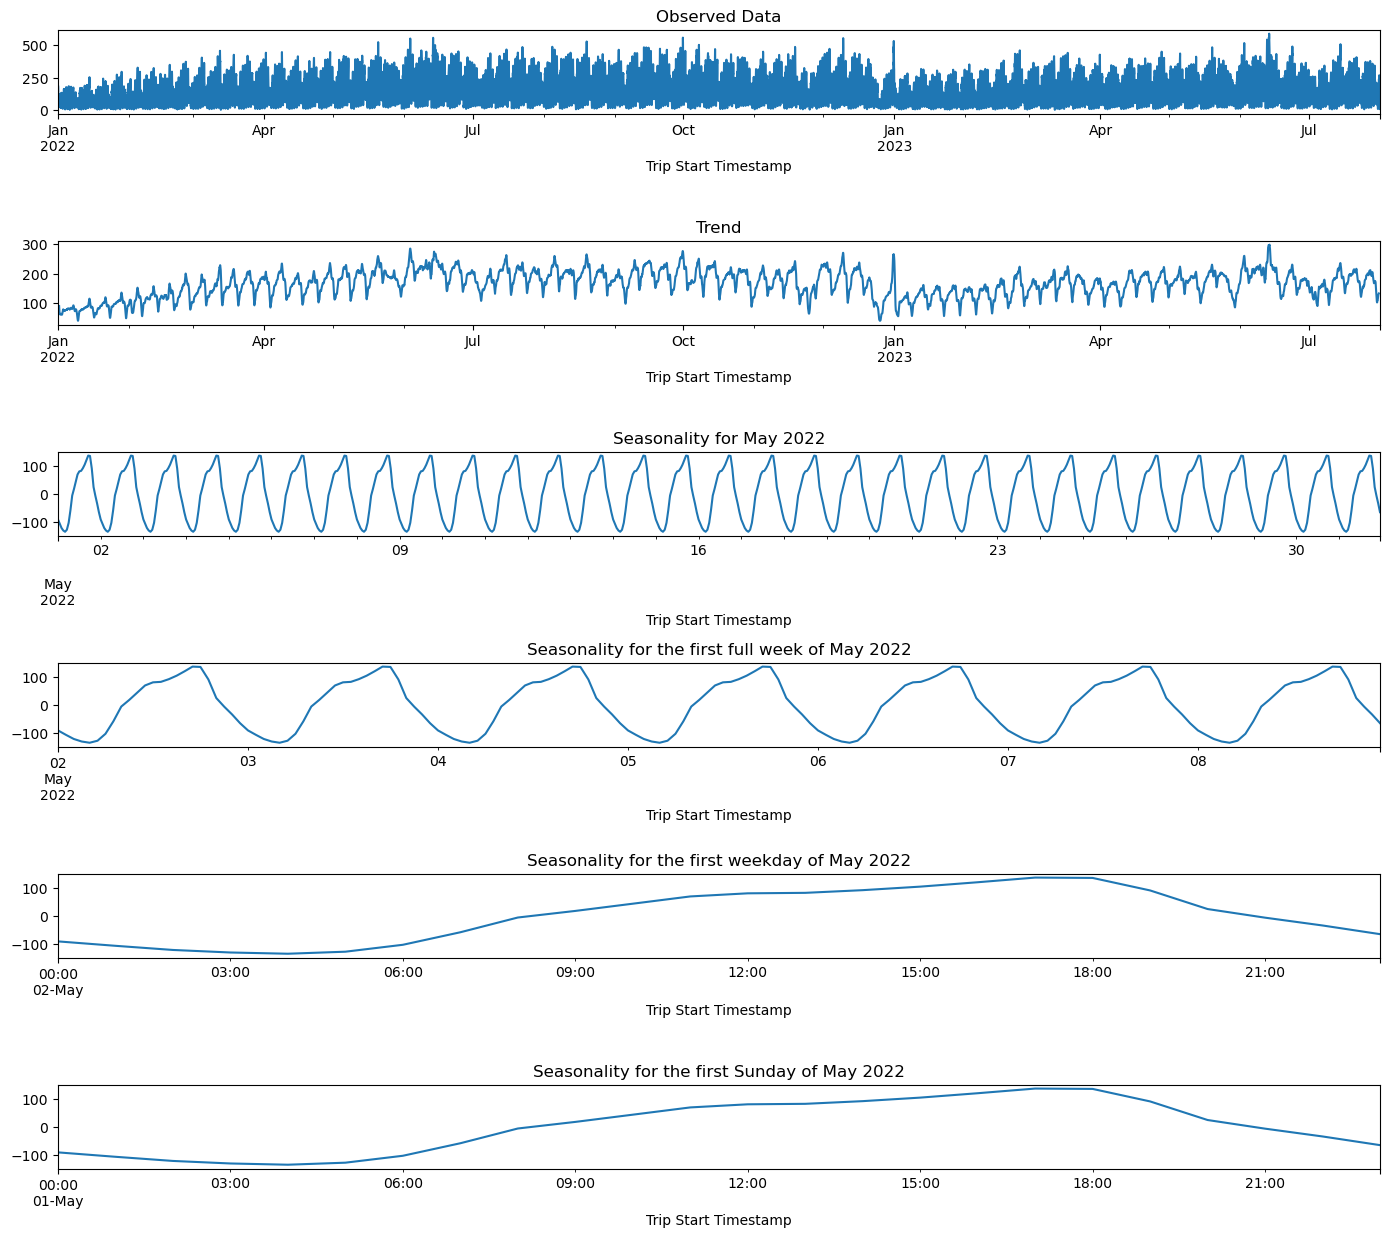

In [25]:
# Filtering data for Pickup Community Area 8
data_filtered = data.filter(data["Pickup Community Area"] == 8)

# Converting to a Pandas DataFrame
pdf = data_filtered.toPandas()

# Converting 'Trip Start Timestamp' to datetime
pdf['Trip Start Timestamp'] = pd.to_datetime(pdf['Trip Start Timestamp'])

# Indexing by 'Trip Start Timestamp'
pdf.set_index('Trip Start Timestamp', inplace=True)

# Applying seasonal_decompose
result = seasonal_decompose(pdf['num_orders'], period=24)

# Plotting the results
plt.figure(figsize=(14,14))

# Observed data
plt.subplot(711)
result.observed.plot(title='Observed Data')

# Trend
plt.subplot(712)
result.trend.plot(title='Trend')

# Seasonality for May 2022
plt.subplot(713)
result.seasonal['2022-05'].plot(title='Seasonality for May 2022')

# Seasonality for the first full week of May (Monday to Sunday inclusive)
plt.subplot(714)
result.seasonal['2022-05-02':'2022-05-08'].plot(title='Seasonality for the first full week of May 2022')

# Seasonality for the first weekday of May
plt.subplot(715)
result.seasonal['2022-05-02'].plot(title='Seasonality for the first weekday of May 2022')

# Seasonality for the first Sunday of May
plt.subplot(716)
result.seasonal['2022-05-01'].plot(title='Seasonality for the first Sunday of May 2022')

plt.tight_layout()
plt.show()

#### Data for city district 76.

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


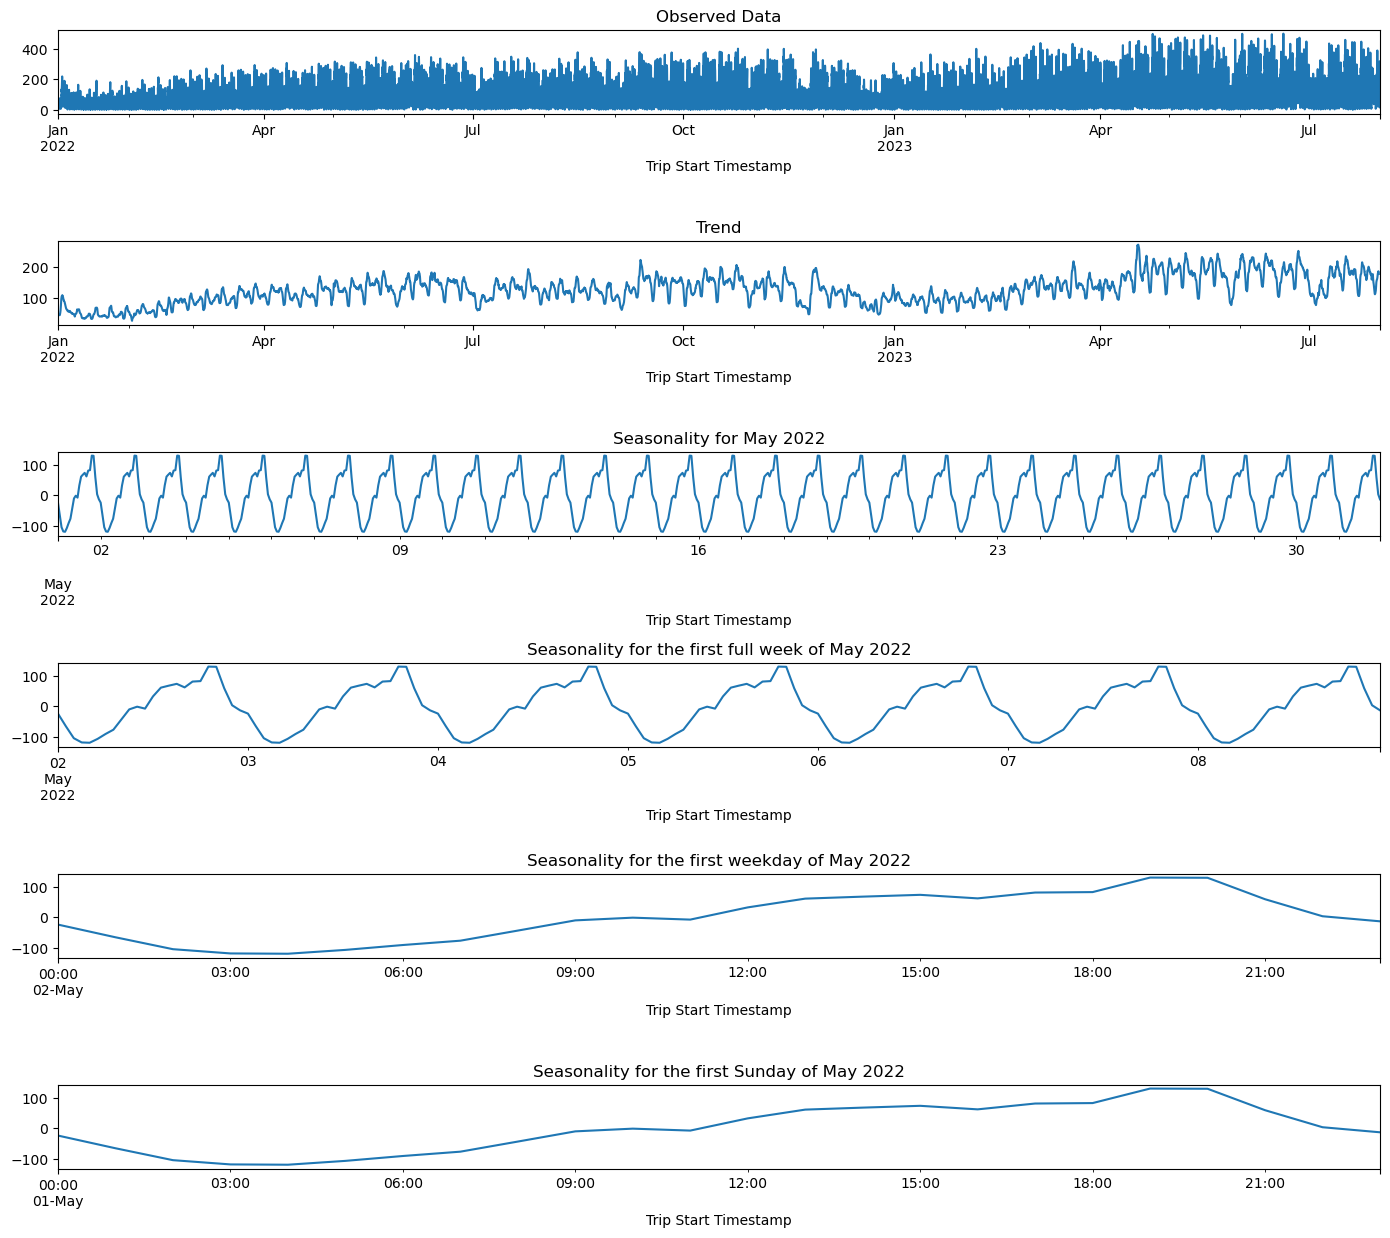

In [26]:
# Filtering data for Pickup Community Area 76
data_filtered = data.filter(data["Pickup Community Area"] == 76)

# Converting to a Pandas DataFrame
pdf = data_filtered.toPandas()

# Converting 'Trip Start Timestamp' to datetime
pdf['Trip Start Timestamp'] = pd.to_datetime(pdf['Trip Start Timestamp'])

# Indexing by 'Trip Start Timestamp'
pdf.set_index('Trip Start Timestamp', inplace=True)

# Applying seasonal_decompose
result = seasonal_decompose(pdf['num_orders'], period=24)

# Plotting the results
plt.figure(figsize=(14,14))

# Observed data
plt.subplot(711)
result.observed.plot(title='Observed Data')

# Trend
plt.subplot(712)
result.trend.plot(title='Trend')

# Seasonality for May 2022
plt.subplot(713)
result.seasonal['2022-05'].plot(title='Seasonality for May 2022')

# Seasonality for the first full week of May (Monday to Sunday inclusive)
plt.subplot(714)
result.seasonal['2022-05-02':'2022-05-08'].plot(title='Seasonality for the first full week of May 2022')

# Seasonality for the first weekday of May
plt.subplot(715)
result.seasonal['2022-05-02'].plot(title='Seasonality for the first weekday of May 2022')

# Seasonality for the first Sunday of May
plt.subplot(716)
result.seasonal['2022-05-01'].plot(title='Seasonality for the first Sunday of May 2022')

plt.tight_layout()
plt.show()

#### Plotting the histogram for each district on aggregated data.

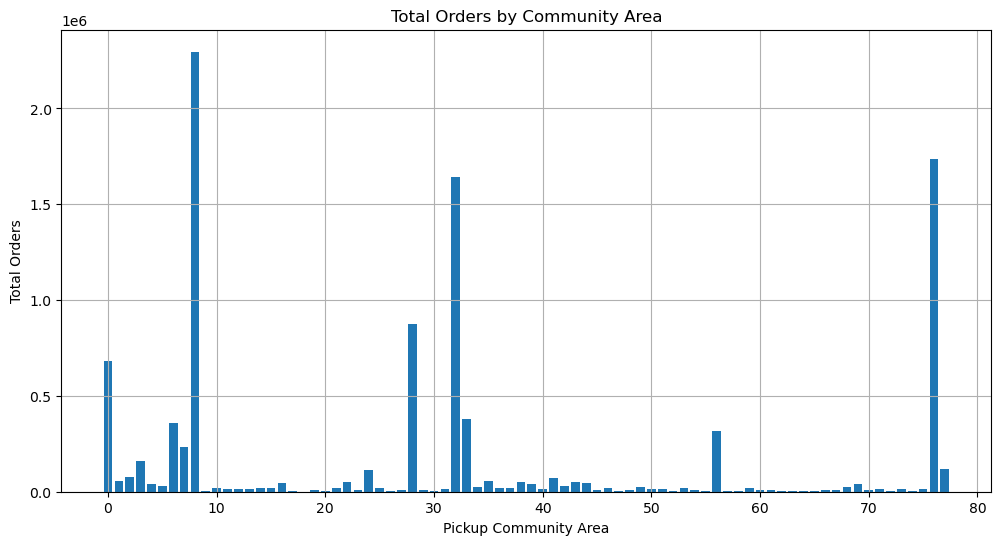

In [27]:
# Group the data by Pickup Community Area and sum the total orders
agg_data = data.groupBy("Pickup Community Area").agg(F.sum("num_orders").alias("total_orders"))

# Convert to a Pandas DataFrame
agg_df = agg_data.toPandas()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(agg_df["Pickup Community Area"], agg_df["total_orders"])
plt.xlabel('Pickup Community Area')
plt.ylabel('Total Orders')
plt.title('Total Orders by Community Area')
plt.grid()
plt.show()

#### **Conclusions:**

- Data for different districts significantly differ - the peak of orders occurs at different time periods.
- However, in all districts, the highest number of orders occurs between 6:00 AM and 9:00 PM, while there are very few orders from 9:00 PM to 6:00 AM.
- The orders are distributed very unevenly across the districts. Therefore, it is necessary to try training separate models for each district.

## Feature engineering.

In [28]:
# Converting Trip Start Timestamp to unix timestamp (epoch time)
data = data.withColumn("timestamp", unix_timestamp("Trip Start Timestamp", 'yyyy-MM-dd HH:mm:ss').cast("double"))

### Extracting features from the 'date_hour' column.

In [29]:
# Extracting year from Trip Start Timestamp
data = data.withColumn("year", F.year("Trip Start Timestamp"))

# Extracting month from date_hour
data = data.withColumn("month", F.month("Trip Start Timestamp"))

# Extracting day of week from date_hour
data = data.withColumn("day_of_week", dayofweek("Trip Start Timestamp"))
data = data.withColumn("day_of_week", ((data["day_of_week"] - 2) % 7) + 1)

# Extracting day of month from date_hour
data = data.withColumn("day_of_month", F.dayofmonth("Trip Start Timestamp"))

# Extracting hour from date_hour
data = data.withColumn("hour", F.hour("Trip Start Timestamp"))

### Creating a column with time of day categorization.

In [30]:
data = data.withColumn("daytime", 
                       when((data["hour"] >= 6) & (data["hour"] <= 21), "day")
                       .otherwise("night"))

### Creating numerical features based on cyclic categorical features extracted from the date.

In [31]:
# Creating new numerical features
data = data.withColumn("hour_sin", sin(2 * pi * data['hour'] / 24.0))
data = data.withColumn("hour_cos", cos(2 * pi * data['hour'] / 24.0))

data = data.withColumn("day_of_month_sin", sin(2 * pi * data['day_of_month'] / 31.0))
data = data.withColumn("day_of_month_cos", cos(2 * pi * data['day_of_month'] / 31.0))

data = data.withColumn("day_of_week_sin", sin(2 * pi * data['day_of_week'] / 7.0))
data = data.withColumn("day_of_week_cos", cos(2 * pi * data['day_of_week'] / 7.0))

data = data.withColumn("month_sin", sin(2 * pi * data['month'] / 12.0))
data = data.withColumn("month_cos", cos(2 * pi * data['month'] / 12.0))

# Dropping the categorical features from which numerical features were extracted
data = data.drop('month', 'day_of_week', 'day_of_month', 'hour')

In [32]:
data.show(5)

+--------------------+---------------------+----------+-----------+----+-------+--------+--------+-------------------+------------------+-------------------+------------------+-------------------+------------------+
|Trip Start Timestamp|Pickup Community Area|num_orders|  timestamp|year|daytime|hour_sin|hour_cos|   day_of_month_sin|  day_of_month_cos|    day_of_week_sin|   day_of_week_cos|          month_sin|         month_cos|
+--------------------+---------------------+----------+-----------+----+-------+--------+--------+-------------------+------------------+-------------------+------------------+-------------------+------------------+
| 2022-01-01 00:00:00|                    0|        17|1.6409952E9|2022|  night|     0.0|     1.0|0.20129852008866006|0.9795299412524945|-0.7818314824680299|0.6234898018587334|0.49999999999999994|0.8660254037844387|
| 2022-01-01 00:00:00|                    1|         1|1.6409952E9|2022|  night|     0.0|     1.0|0.20129852008866006|0.9795299412524945

### Creating columns with lag values for the corresponding city district over the previous 336 hours.

In [33]:
# Defining the window specification
window_spec = Window.partitionBy("Pickup Community Area") \
                    .orderBy("Trip Start Timestamp")

# Adding lag columns for each of the previous 216 hours
for i in range(1, 217):
    data = data.withColumn(f"lag_{i}", F.lag("num_orders", i).over(window_spec))

### Creating columns with rolling averages for the corresponding city district over the previous 24 hours.

In [34]:
# Defining a window specification for 24 hours
window_spec_24h = Window.partitionBy("Pickup Community Area").orderBy("Trip Start Timestamp").rowsBetween(-24, -1)

# Calculating rolling average over 24 hours
data = data.withColumn("rolling_avg_24h", F.avg("num_orders").over(window_spec_24h))

### Removing rows with missing values.

In [35]:
data = data.dropna()

### Sorting the resulting dataset by timestamp.

In [36]:
data = data.sort("timestamp")

### Splitting the resulting data into training and testing sets while preserving the temporal order.

In [37]:
data = data.withColumn("rank", percent_rank().over(Window.orderBy("timestamp")))
train = data.where("rank <= .8").drop("rank")
test = data.where("rank > .8").drop("rank")

## Training and testing a linear regression model.

### Preparing data for training a linear regression model.

In [38]:
# Defining categorical and numerical features
cat_features = ["Pickup Community Area", "year", "daytime"]
num_features = [f"lag_{i}" for i in range(1, 217)] + ["rolling_avg_24h"] + \
              ["hour_sin", "hour_cos", "day_of_month_sin", "day_of_month_cos", \
              "day_of_week_sin", "day_of_week_cos", "month_sin", "month_cos"]

# Creating pipeline components
# Converting text categories to numerical representation
categorical_indexer = StringIndexer(inputCols=cat_features, 
                                    outputCols=[f"{c}_indexed" for c in cat_features],
                                    handleInvalid='keep')

# Applying one-hot encoding to categories
encoder = OneHotEncoder(inputCols=[f"{c}_indexed" for c in cat_features],
                        outputCols=[f"{c}_vec" for c in cat_features])

# Consolidating features using VectorAssembler
final_assembler = VectorAssembler(inputCols=[f"{c}_vec" for c in cat_features] + num_features, outputCol="features")

# Creating and training the pipeline
pipeline = Pipeline(stages=[categorical_indexer, encoder, final_assembler])
pipeline_model = pipeline.fit(train)

In [39]:
# Applying the pipeline
train = pipeline_model.transform(train)
test = pipeline_model.transform(test)

### Model training.

In [40]:
lr = LinearRegression(featuresCol="features", labelCol="num_orders", regParam=0.1, maxIter=200)
lr_model = lr.fit(train)

### Preparing predictions and evaluating the model's performance.

In [41]:
%%time
# Making predictions on the test set
predictions = lr_model.transform(test)

# Model evaluation
evaluator_mae = RegressionEvaluator(
    labelCol="num_orders", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test set = {round(mae, 2)}")

Mean Absolute Error (MAE) on the test set = 2.18
CPU times: user 87.6 ms, sys: 15.3 ms, total: 103 ms
Wall time: 3min 28s


## Training and testing linear regression models for each district.

In [43]:
# Creating lists to store metrics for each model
mae_values = []

# Training the model for each district
for i in tqdm(range(78)):
    # Selecting data for the current district
    train_data = train.filter(train["Pickup Community Area"] == i)
    test_data = test.filter(test["Pickup Community Area"] == i)
    
    # Training the model
    lr = LinearRegression(featuresCol="features", labelCol="num_orders")
    lr_model = lr.fit(train_data)
    
    # Making predictions
    predictions = lr_model.transform(test_data)
    
    # Calculating MAE
    evaluator_mae = RegressionEvaluator(
        labelCol="num_orders", predictionCol="prediction", metricName="mae")
    mae = evaluator_mae.evaluate(predictions)
    mae_values.append(mae)

    # Deleting variables and running garbage collector
    del train_data, test_data, lr, lr_model, predictions, evaluator_mae
    gc.collect()

# Running garbage collector after completing the loop
gc.collect()

100%|██████████| 78/78 [24:51:30<00:00, 1147.31s/it]   


0

In [44]:
# Calculating mean MAE
mean_mae = np.mean(mae_values)
print(f"Mean Absolute Error (MAE) on the test set = {round(mean_mae, 2)}")

Mean Absolute Error (MAE) on the test set = 2.05


## Project summary report.

Two datasets containing taxi order information from January 2022 to July 2023, inclusive, were provided. The date and time of each order were rounded to the nearest 15 minutes.

During data preprocessing, columns unrelated to the target variable's features were removed. Missing values in the column indicating city districts were filled by assigning a value of 0 to represent suburban trips.

Next, data was aggregated by hour and city districts. The resulting table, aimed at filling gaps in time series data, was merged with an artificially created table, with one row for each hour and city district within the specified time range.

In the feature engineering stage, time-related features were extracted. Cyclical time features were transformed from categorical to quantitative variables using sine and cosine functions. Lag values and rolling averages were also computed.

Subsequently, data for different city districts was decomposed into trends and seasonality, revealing that orders throughout the day and the overall number of orders in different areas of the city are distributed non-uniformly.

The linear regression model trained on the additional features demonstrated performance metrics with a Mean Absolute Error (MAE) of 2.18.

Training separate linear regression models for each district reduced MAE to 2.05.